In [1]:
import sys

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from IPython.display import clear_output

sys.path.append('../')

from dataset import Pipeline, B, V, F
from dataset.models.tf import TFModel, FasterRCNN
from dataset.opensets import MNIST
from detection_mnist import DetectionMnist

In [2]:
IMAGE_SHAPE = (90, 90)
DIGITS_PER_IMAGE = (5, 10)
RESIZE_TO = (15, 15)

BATCH_SIZE = 16

In [3]:
mnist = MNIST(batch_class=DetectionMnist)

ExtractingExtractingExtractingExtracting    C:\Users\kozhevin\AppData\Local\Temp\train-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\train-labels-idx1-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-images-idx3-ubyte.gzC:\Users\kozhevin\AppData\Local\Temp\t10k-labels-idx1-ubyte.gz





In [4]:
feed_dict = {'images': B('images'),
             'labels': B('labels'),
             'bboxes': B('bboxes'),
             }    

feed_dict_rpn = {**feed_dict,
                'train_mode': True}

feed_dict_rcn = {**feed_dict,
                'train_mode': False}

In [5]:
placeholder_config = {'images': {'shape': (1,) + IMAGE_SHAPE,
                                 'dtype': 'float32',
                                 'data_format': 'channels_first'}}

In [6]:
rpn_config = {'batch_size': F(lambda batch: len(batch.data.images)),
              'anchors_batch': 16,
              'inputs': placeholder_config,
              'input_block/inputs': 'images',
              'batch_norm': {'momentum': 0.1},
              'loss': None,
              'optimizer': 'Adam'}

In [7]:
train_rpn = (mnist.train.p
            .init_variable('loss', init_on_each_run=list)
            .init_model('dynamic', FasterRCNN, 'FasterRCNN', config=rpn_config)
            .generate_images(image_shape=IMAGE_SHAPE, 
                             n_digits=DIGITS_PER_IMAGE, 
                             resize_to=RESIZE_TO)
            .swap_axis()
            .train_model('FasterRCNN', 
                          feed_dict=feed_dict_rpn, 
                          fetches='loss', 
                          save_to=V('loss'), mode='a'))

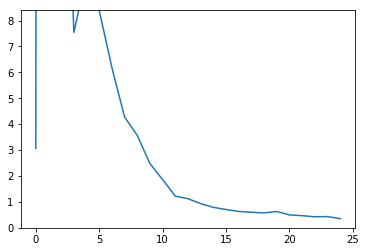

In [8]:
for i in range(25):
    train_rpn.next_batch(BATCH_SIZE)
    
    clear_output(True)
    current_max = np.max(train_rpn.get_variable('loss')[-20:])
    plt.plot(train_rpn.get_variable('loss'))
    plt.ylim([0,current_max])
    plt.show()

In [9]:
train_rcn = (mnist.train.p
            .init_variable('rpn_loss', init_on_each_run=list)
            .init_variable('rcn_loss', init_on_each_run=list)
            .import_model('FasterRCNN', train_rpn)
            .generate_images(image_shape=IMAGE_SHAPE, 
                             n_digits=DIGITS_PER_IMAGE, 
                             resize_to=RESIZE_TO)
            .swap_axis()
            .train_model('FasterRCNN', 
                          feed_dict=feed_dict_rpn, 
                          fetches=['loss'], 
                          save_to=[V('rpn_loss')], mode='a')
            .train_model('FasterRCNN', 
                          feed_dict=feed_dict_rcn, 
                          fetches=['loss'], 
                          save_to=[V('rcn_loss')], mode='a'))

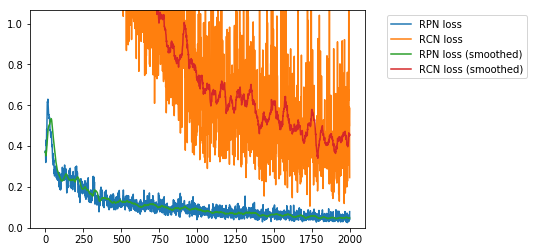

In [11]:
def smooth(y, window=30, momentum=1):
    def _ma(y, window, momentum):
        momentum = np.float32(momentum)
        window = min(window, len(y))
        weights = momentum ** np.arange(-window+1, 1)
        return sum(y[-window:] * weights) / sum(weights)
    res = []
    for i, value in enumerate(y):
        res.append(_ma(y[:i+1], window, momentum))
    return res

for i in range(2000):
    train_rcn.next_batch(BATCH_SIZE)
    clear_output(True)
    current_max = np.max(train_rcn.get_variable('rcn_loss')[-100:])
    plt.plot(train_rcn.get_variable('rpn_loss'), label='RPN loss')
    plt.plot(train_rcn.get_variable('rcn_loss'), label='RCN loss')
    plt.plot(smooth(train_rcn.get_variable('rpn_loss')), label='RPN loss (smoothed)')
    plt.plot(smooth(train_rcn.get_variable('rcn_loss')), label='RCN loss (smoothed)')
    plt.ylim([0,current_max])
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
    plt.show()

In [12]:
test = (mnist.test.p
            .init_variable('rpn_reg', init_on_each_run=list)
            .init_variable('rpn_clsf', init_on_each_run=list)
            .init_variable('rcn_clsf', init_on_each_run=list)
            .import_model('FasterRCNN', train_rpn)
            .generate_images(image_shape=IMAGE_SHAPE, 
                             n_digits=DIGITS_PER_IMAGE, 
                             resize_to=(15,15))
            .swap_axis()
            .predict_model('FasterRCNN', 
                          feed_dict=feed_dict_rcn, 
                          fetches=['roi', 'targets', 'rcn_output'], 
                          save_to=[V('rpn_reg'), V('rpn_clsf'), V('rcn_clsf')], mode='a'))

In [13]:
batch = test.next_batch(BATCH_SIZE)

In [14]:
roi = test.get_variable('rpn_reg')[-1]
targets = test.get_variable('rpn_clsf')[-1]
predictions = test.get_variable('rcn_clsf')[-1]

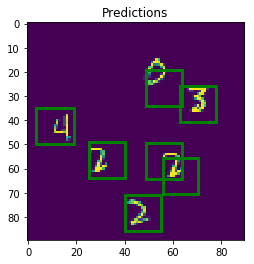

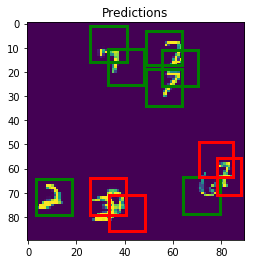

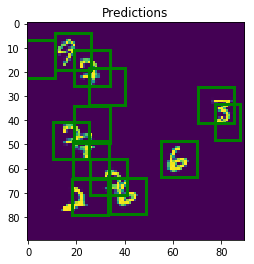

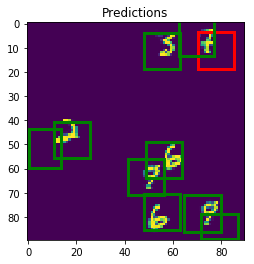

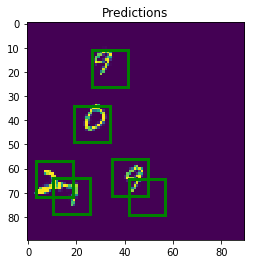

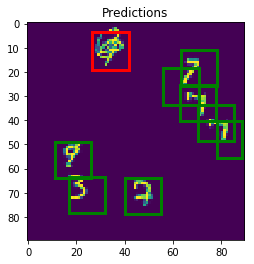

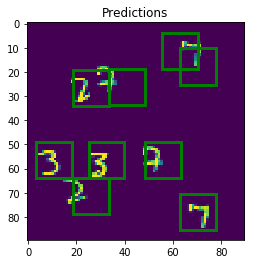

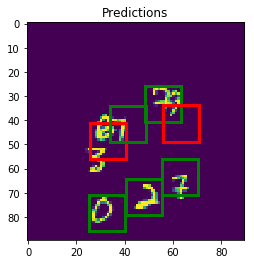

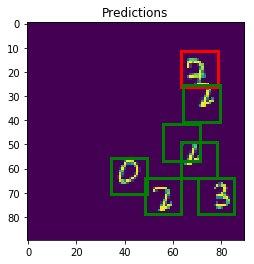

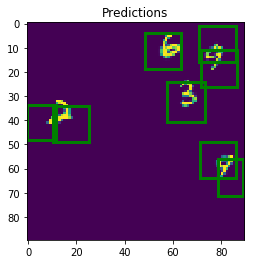

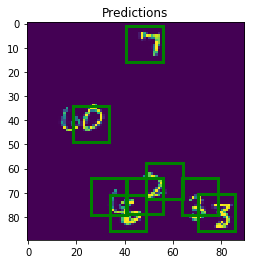

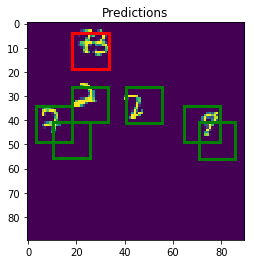

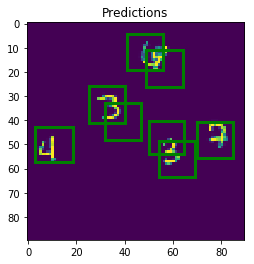

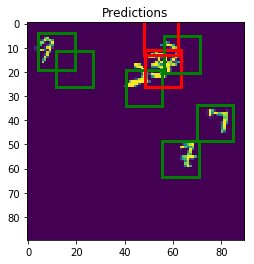

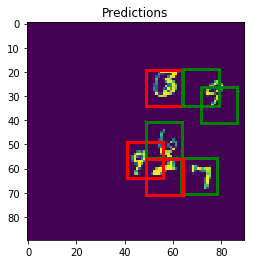

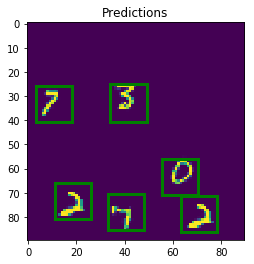

In [15]:
for i in range(BATCH_SIZE):
    im = np.squeeze(batch.data.images[i])
    bboxes = roi[i]
    
    fig, ax = plt.subplots(1)

    ax.imshow(im)

    for j, bbox in enumerate(bboxes):      
        color = 'g' if predictions[i][j] == targets[i][j] else 'r' 
        rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3], bbox[2], linewidth=3, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
    plt.title('Predictions')
    plt.show()

In [16]:
feed_dict = {'images': B('images')}  

test = (mnist.test.p
            .init_variable('rpn_reg', init_on_each_run=list)
            .init_variable('rcn_clsf', init_on_each_run=list)
            .import_model('FasterRCNN', train_rpn)
            .generate_images(image_shape=IMAGE_SHAPE, 
                             n_digits=DIGITS_PER_IMAGE, 
                             resize_to=(15,15))
            .swap_axis()
            .predict_model('FasterRCNN', 
                          feed_dict=feed_dict, 
                          fetches=['roi', 'rcn_output'], 
                          save_to=[V('rpn_reg'), V('rcn_clsf')], mode='a'))

In [17]:
batch = test.next_batch(BATCH_SIZE)
roi = test.get_variable('rpn_reg')[-1]
predictions = test.get_variable('rcn_clsf')[-1]

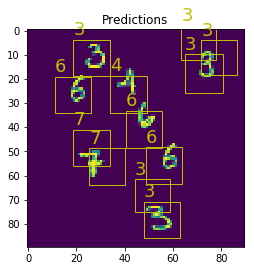

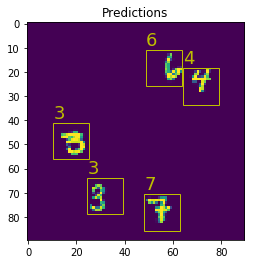

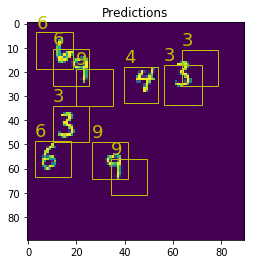

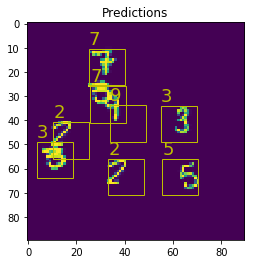

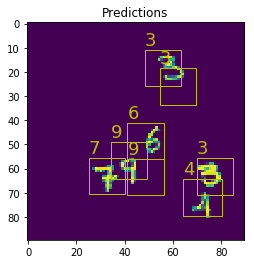

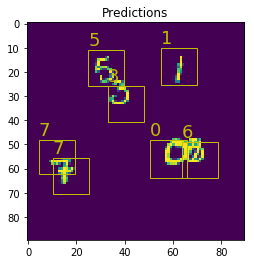

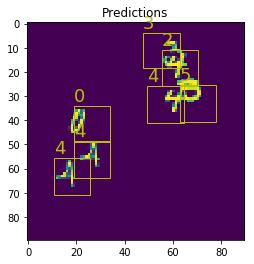

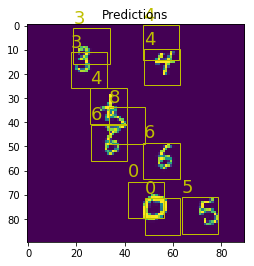

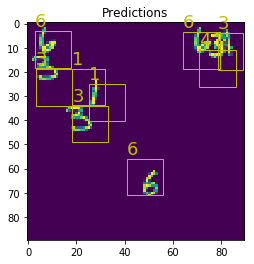

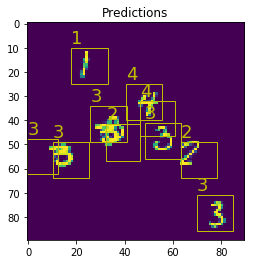

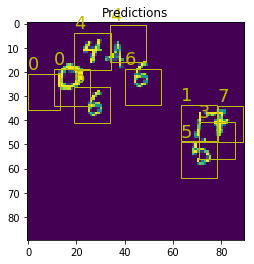

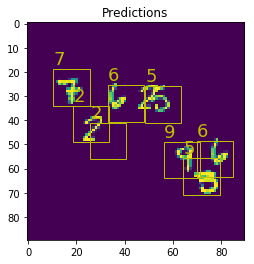

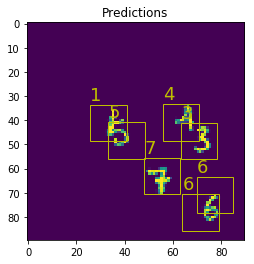

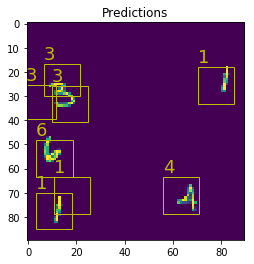

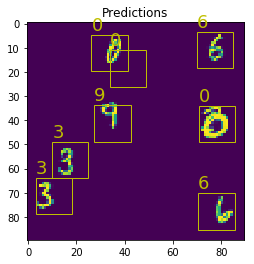

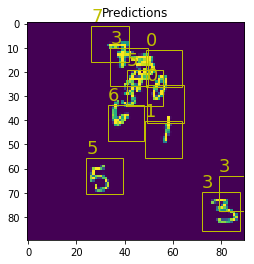

In [18]:
for i in range(BATCH_SIZE):
    im = np.squeeze(batch.data.images[i])
    bboxes = roi[i]
    
    fig, ax = plt.subplots(1)

    ax.imshow(im)

    for j, bbox in enumerate(bboxes):      
        rect = patches.Rectangle((bbox[1], bbox[0]), bbox[3], bbox[2], linewidth=1, edgecolor='y', facecolor='none')
        plt.text(bbox[1], bbox[0]-2, predictions[i][j], color='y', size=18)
        ax.add_patch(rect)
        
    plt.title('Predictions')
    plt.show()